# Laboratorium 2 - wieloręcy bandyci

## Przygotowanie

 * [opcjonalnie] Utwórz wirtualne środowisko
 `python3 -m venv ./recsyslab2`
 * zainstaluj potrzebne biblioteki:
 `pip3 install matplotlib tabulate`
 * upewnij się, że plik `bandit_framework.py` najduje się w tym samym katalogu

## Część 1. - framework i naiwni bandyci

In [1]:
# importujemy wszystkie potrzebne pakiety

from copy import copy
from itertools import product
from math import log, sqrt
from tabulate import tabulate
from random import betavariate, normalvariate, random, sample, shuffle, uniform
from bandit_framework import * # pakiet ze srodowiskiem testowym

In [2]:
# inicjalizujemy parametry testu

runs = 50
epochs = 100
recommendation_size = 10

In [3]:
# inicjalizujemy ramiona bandytow - payout kazdego ramienia bedzie reprezentowany przez rozklad normalny
#   te ramiona dobrze reprezentują CTR, czyli funkcje celu o rozkladzie Bernoulliego
#   - mamy prawdopodobienstwo aktywacji (klikniecia) p i staly payout po kliknieciu
# Mozemy takze przygotowac inne typy ramion, np. z payoutem losowanym z rozkladu normalnego lub wykladniczego

good_arms = [Arm(f'good_{i}', uniform(0.5, 0.7), lambda: 1) for i in range(10)]
bad_arms = [Arm(f'bad_{i}', uniform(0.1, 0.4), lambda: 1) for i in range(90)]
arms = good_arms + bad_arms
shuffle(arms)
arms = {arm.arm_id: arm for arm in arms}
arm_ids = list(arms.keys())

In [4]:
expected_highest_payout_per_epoch = sum(sorted([arm.activation_probability for arm in arms.values()], reverse=True)[:10])
print(f'Expected highest average payout per epoch: {expected_highest_payout_per_epoch}')

Expected highest average payout per epoch: 5.902849381583825


In [5]:
# pierwszy bandyta - wybiera losowe ramiona

class Random(Bandit):
    def __init__(self, bandit_id, arm_ids):
        super().__init__(bandit_id, arm_ids)
    
    def recommend(self, size):
        return sample(self.arm_ids, size)
    
    def feedback(self, arm_id, payout):
        pass

In [6]:
# ten bandyta oszukuje - zna mozliwosci kazdego z ramion i wybiera najelpsze - przyda nam sie do porownania

class Perfect(Bandit):
    def __init__(self, bandit_id, arm_ids, arms):
        super().__init__(bandit_id, arm_ids)
        self.arms = arms
        self.expected_payouts = {}
        for arm in arms.values():
            self.expected_payouts[arm.arm_id] = self.__find_expected_value(arm.payout_function) * arm.activation_probability
        self.arm_ids_sorted_by_expected_payout = [x[0] for x in sorted(self.expected_payouts.items(), key=lambda x: x[1], reverse=True)]

    def recommend(self, size):
        return self.arm_ids_sorted_by_expected_payout[:size]
    
    def feedback(self, arm_id, payout):
        pass
    
    def __find_expected_value(self, payout_function, n=100000):
        # brzydka, ale skuteczna sztuczka, zeby metoda brute-force znalezc wartosc oczekiwana
        return sum([payout_function() for i in range(n)]) / n

In [7]:
# tworzymy liste bandytow do przetestowania

bandits = [
    Random('random', arm_ids),
    Perfect('perfect', arm_ids, arms)
]

In [8]:
# uruchamiamy test

runner = Runner(arms, bandits)
results = runner.simulate(runs, epochs, recommendation_size)

Simulating: random
Simulating: perfect



Aggregated results:

perfect: 589.6
random: 286.4599999999999


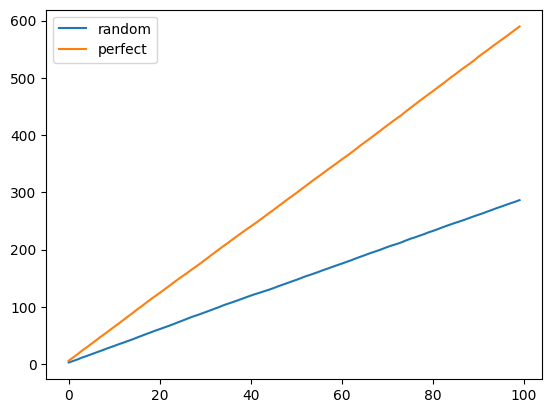

In [9]:
# wyniki sumaryczne dla wszystkich epok

runner.plot_results(results, runs, epochs, mode='cumulative')


Aggregated results:

perfect: 5.92
random: 2.92


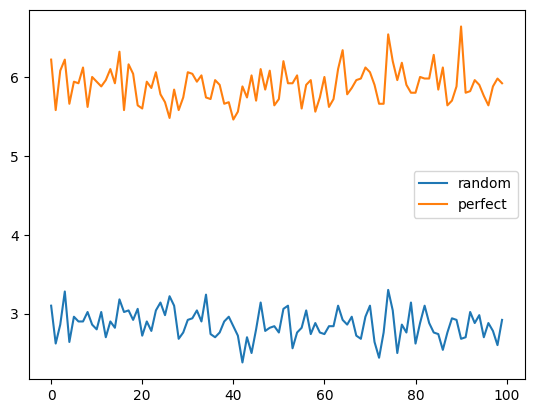

In [10]:
# wyniki per epoka

runner.plot_results(results, runs, epochs, mode='average')

## Część 2. - bandyci właściwi

In [11]:
from random import random, shuffle


class EGreedy(Bandit):
    def __init__(self, bandit_id, arm_ids, epsilon):
        super().__init__(bandit_id, arm_ids)
        self.epsilon = epsilon

        self.impressions = {arm_id: 0 for arm_id in arm_ids}
        self.clicks = {arm_id: 0 for arm_id in arm_ids}
        self.ctr = {arm_id: 0.0 for arm_id in arm_ids}

    def recommend(self, size):
        sorted_arms = sorted(self.arm_ids, key=lambda arm_id: self.ctr[arm_id], reverse=True)
        random_arms = [arm_id for arm_id in self.arm_ids]
        shuffle(random_arms)

        recommendations = []
        for arm1, arm2 in zip(sorted_arms, random_arms):
            if random() > self.epsilon:
                recommendations.append(arm1)
            else:
                recommendations.append(arm2)
        
        unique_recommendations = []
        for r in recommendations:
            if r not in unique_recommendations:
                unique_recommendations.append(r)
            if len(unique_recommendations) == size:
                break

        return unique_recommendations

    def feedback(self, arm_id, payout):
        if payout > 0:
            self.clicks[arm_id] += 1
        self.impressions[arm_id] += 1
        self.ctr[arm_id] = self.clicks[arm_id] / self.impressions[arm_id]

In [12]:
class UCB(Bandit):
    def __init__(self, bandit_id, arm_ids, optimism_weight):
        super().__init__(bandit_id, arm_ids)
        self.optimism_weight = optimism_weight

        self.impressions = {arm_id: 0 for arm_id in arm_ids}
        self.clicks = {arm_id: 0 for arm_id in arm_ids}
        self.ctr = {arm_id: 0.0 for arm_id in arm_ids}
        self.total_impressions = 0

    def recommend(self, size):
        return sorted(self.arm_ids, key=lambda arm_id: self.ctr[arm_id] + self._optimism(arm_id), reverse=True)[:size]

    def feedback(self, arm_id, payout):
        if payout > 0:
            self.clicks[arm_id] += 1

        self.impressions[arm_id] += 1
        self.total_impressions += 1
        self.ctr[arm_id] = self.clicks[arm_id] / self.impressions[arm_id]

    def _optimism(self, arm_id):
        return (
            self.optimism_weight * sqrt(2 * log(self.total_impressions) / self.impressions[arm_id])
            if self.impressions[arm_id] > 0
            else +float("inf")
        )

In [13]:
class ThompsonSampling(Bandit):
    def __init__(self, bandit_id, arm_ids, reward_multiplier, regret_multiplier):
        super().__init__(bandit_id, arm_ids)
        self.reward_multiplier = reward_multiplier
        self.regret_multiplier = regret_multiplier
        self.a = {arm_id: 1 for arm_id in arm_ids}
        self.b = {arm_id: 1 for arm_id in arm_ids}
    
    def recommend(self, size):
        return sorted(self.arm_ids, key=lambda arm_id: betavariate(self.a[arm_id], self.b[arm_id]), reverse=True)[:size]
    
    def feedback(self, arm_id, payout):
        if payout > 0:
            self.a[arm_id] += self.reward_multiplier
        else:
            self.b[arm_id] += self.regret_multiplier
    

## Część 3. - zgrubne porównanie bandytów

In [14]:
bandits = [
    Random('random', arm_ids),
    Perfect('perfect', arm_ids, arms)
]
# nie wahaj sie wybrac innych wartosci parametrow bandytow
bandits.extend([EGreedy('egreedy_%s' % epsilon, arm_ids, epsilon) for epsilon in [0.01, 0.05, 0.1, 0.25]])
bandits.extend([UCB('ucb_%s' % optimism_weight, arm_ids, optimism_weight) for optimism_weight in [0.01, 0.1, 1, 10]])
bandits.extend([ThompsonSampling('ts_%s_%s' % (reward_weight, regret_weight), arm_ids, reward_weight, regret_weight)
                for reward_weight, regret_weight in product([1, 5, 10, 20, 50], [1, 5, 10, 20, 50])])

In [15]:
runner = Runner(arms, bandits)
results = runner.simulate(runs, epochs, recommendation_size)

Simulating: random
Simulating: perfect
Simulating: egreedy_0.01
Simulating: egreedy_0.05
Simulating: egreedy_0.1
Simulating: egreedy_0.25
Simulating: ucb_0.01
Simulating: ucb_0.1
Simulating: ucb_1
Simulating: ucb_10
Simulating: ts_1_1
Simulating: ts_1_5
Simulating: ts_1_10
Simulating: ts_1_20
Simulating: ts_1_50
Simulating: ts_5_1
Simulating: ts_5_5
Simulating: ts_5_10
Simulating: ts_5_20
Simulating: ts_5_50
Simulating: ts_10_1
Simulating: ts_10_5
Simulating: ts_10_10
Simulating: ts_10_20
Simulating: ts_10_50
Simulating: ts_20_1
Simulating: ts_20_5
Simulating: ts_20_10
Simulating: ts_20_20
Simulating: ts_20_50
Simulating: ts_50_1
Simulating: ts_50_5
Simulating: ts_50_10
Simulating: ts_50_20
Simulating: ts_50_50



Aggregated results:

ts_5_1: 6.1
ts_5_20: 6.06
perfect: 5.92
ts_1_5: 5.9
ts_1_50: 5.86
ts_1_1: 5.84
ts_1_20: 5.82
ts_5_10: 5.78
ts_1_10: 5.76
ts_10_1: 5.62
ts_20_1: 5.6
egreedy_0.01: 5.56
ts_5_50: 5.48
ts_5_5: 5.46
ts_10_5: 5.46
egreedy_0.1: 5.42
ts_20_5: 5.3
egreedy_0.05: 5.2
ts_20_20: 5.2
ucb_0.1: 5.08
ts_10_20: 5.06
egreedy_0.25: 5.04
ts_20_10: 5.04
ts_50_1: 4.96
ts_50_20: 4.9
ts_20_50: 4.88
ts_10_10: 4.86
ts_50_50: 4.8
ts_10_50: 4.7
ucb_0.01: 4.62
ucb_1: 4.58
ts_50_10: 4.54
ts_50_5: 4.22
random: 2.94
ucb_10: 2.9


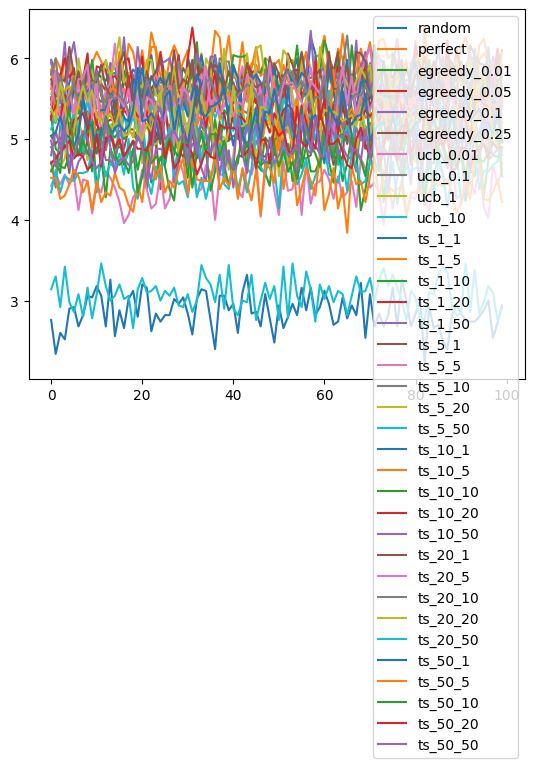

In [16]:
runner.plot_results(results, runs, epochs, mode='average')


Aggregated results:

perfect: 588.5200000000001
ts_1_50: 575.5400000000002
ts_5_1: 575.0599999999997
ts_1_5: 575.0000000000001
ts_1_20: 574.8599999999996
ts_5_20: 573.12
ts_1_10: 571.9400000000003
ts_20_1: 571.0999999999999
ts_1_1: 570.4799999999999
ts_5_5: 562.8000000000001
ts_5_10: 561.42
ts_10_1: 558.52
ts_20_10: 554.24
egreedy_0.1: 549.68
ts_20_5: 547.3599999999999
egreedy_0.05: 543.6600000000002
ts_10_5: 533.42
ts_10_20: 529.08
ts_20_20: 525.0799999999999
ts_50_1: 521.56
ts_5_50: 520.1
ucb_0.1: 514.9
egreedy_0.01: 506.7000000000001
ucb_1: 504.67999999999995
egreedy_0.25: 497.0400000000001
ts_50_20: 491.3399999999997
ts_50_50: 491.23999999999995
ts_10_50: 489.4799999999999
ts_50_10: 482.2000000000001
ts_10_10: 474.90000000000003
ts_20_50: 458.1600000000002
ts_50_5: 444.05999999999983
ucb_0.01: 441.44000000000005
ucb_10: 307.88
random: 285.5


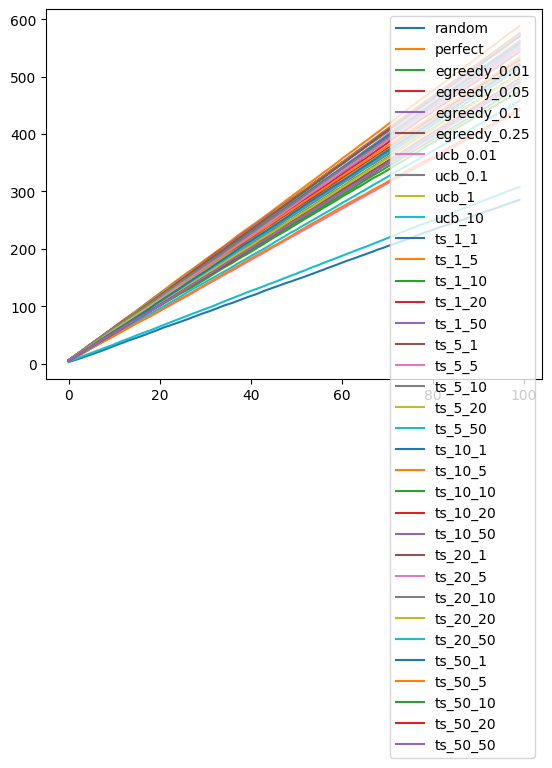

In [17]:
runner.plot_results(results, runs, epochs, mode='cumulative')

## Część 4. - dokładne porównanie bandytów

In [18]:
# obliczmy liste wszystkich dobrych ramion (arm_id zaczyna sie od 'good_') w rekomendacji
def relevant(recommendation: List[Arm]) -> int:
    return len([arm for arm in recommendation if arm.arm_id.startswith('good')])

all_relevant = relevant(arms.values())

In [19]:
# obliczmy precision@k i recall@k (na bazie funkcji relevant())
def precision_at_k(recommendation: List[Arm], k: int) -> float:
    return relevant(recommendation[:k]) / k

def recall_at_k(recommendation: List[Arm], k: int, all_relevant: int) -> float:
    return relevant(recommendation[:k]) / all_relevant

In [20]:
# sprawdzmy, czy dziala
sample_bandit = bandits[-1]
k = 3
recommendation_ids = sample_bandit.recommend(recommendation_size)
recommendation = [arms[arm_id] for arm_id in recommendation_ids]
print(f'Precision@{k} for bandit {sample_bandit.bandit_id}: {precision_at_k(recommendation, k)}')
print(f'Recall@{k} for bandit {sample_bandit.bandit_id}: {recall_at_k(recommendation, k, all_relevant)}')

Precision@3 for bandit ts_50_50: 1.0
Recall@3 for bandit ts_50_50: 0.3


In [21]:
class TestEntry():
    def __init__(self, bandit_name: str, k: int, precision: float, recall: float):
        self.bandit_name = bandit_name
        self.k = k
        self.precision = precision
        self.recall = recall
    
    def tuple(self):
        return (self.bandit_name, self.k, self.precision, self.recall)


def print_test_results(entries: List[TestEntry]):
    data = sorted(sorted([e.tuple() for e in entries], key=lambda e: e[1]), key=lambda e: e[0])
    headers = ('bandit', 'k', 'precision@k', 'recall@k')
    print(tabulate(data, headers, tablefmt='github'))

In [22]:
from statistics import mean

# wybieramy kilku istniejacych, wytrenowanych bandytow (perfect, random, po jednym e-greedy, UCB, TS)
tesing_bandits: list[Bandit] = [
    bandit
    for bandit in bandits
    if bandit.bandit_id
    in [
        "perfect",
        "egreedy_0.1",
        "ucb_1",
        "ts_1_1",
        "random",
    ]
]
# wybieramy wartosci k do porownania
k_vals = [3, 5, 10]
# bedziemy liczyc sredni precision i recall dla `samples` rekomendacji
samples = 10
# miejsce na wyniki
results = []

# dla kazdego bandyty - genetujemy `samples` rekomendacji, liczymy precision i recall, zapisujemy srednie wartosci
# powtarzamy dla kazdego k

# uwaga! przed przeprowadzeniem porownania, bandyci musza sie nauczyc
# pamietaj o uruchomieniu `runner.simulate()` w poprzedniej czesci

for k in k_vals:
    for bandit in tesing_bandits:
        recommendations_ids = [bandit.recommend(recommendation_size) for _ in range(samples)]
        precision = mean(
            precision_at_k([arms[arm_id] for arm_id in recommendation_ids], k)
            for recommendation_ids in recommendations_ids
        )
        recall = mean(
            recall_at_k([arms[arm_id] for arm_id in recommendation_ids], k, all_relevant)
            for recommendation_ids in recommendations_ids
        )
        results.append(
            TestEntry(
                bandit_name=bandit.bandit_id,
                k=k,
                precision=precision,
                recall=recall,
            )
        )

print_test_results(results)

| bandit      |   k |   precision@k |   recall@k |
|-------------|-----|---------------|------------|
| egreedy_0.1 |   3 |     0.966667  |       0.29 |
| egreedy_0.1 |   5 |     0.86      |       0.43 |
| egreedy_0.1 |  10 |     0.9       |       0.9  |
| perfect     |   3 |     1         |       0.3  |
| perfect     |   5 |     1         |       0.5  |
| perfect     |  10 |     1         |       1    |
| random      |   3 |     0.0666667 |       0.02 |
| random      |   5 |     0.12      |       0.06 |
| random      |  10 |     0.11      |       0.11 |
| ts_1_1      |   3 |     1         |       0.3  |
| ts_1_1      |   5 |     1         |       0.5  |
| ts_1_1      |  10 |     0.95      |       0.95 |
| ucb_1       |   3 |     1         |       0.3  |
| ucb_1       |   5 |     1         |       0.5  |
| ucb_1       |  10 |     0.8       |       0.8  |
